### Import librairies
Nous importons les bibliothèque fondamentale pour la programme

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Import donnée
Nous allons importer les données des trainSet et testSet dans les features et la variable à déviner

In [2]:
def importData(path, predictColumn=False):
    columnNames=["ECP","RC","MIN","MAX","MEAN","START","END","DURATION","CV","A1","A2","A3","A4","FP"]
    #columnNames=["RC","MIN","MAX","MEAN","START","END","DURATION","CV","A1","A2","A3","A4","FP"]
    delimit=','
    data = pd.read_csv(path, names=columnNames, sep=delimit)
    #data = data.drop(columns="ECP")
    if predictColumn:
        x=data.iloc[:, 1:-1].values
        y=data['FP'].values
        return x, y
    else:
        x=data.iloc[:,:].values
        return x

In [3]:
#pathTrain='../3-DataSet/dataFinale/p25/traintSet_p25.csv'
pathTrain='../3-DataSet/dataFinale/p27/traintSet_p27.csv'
#pathTrain='../3-DataSet/dataFinale/p30/traintSet_p30.csv'
X_train, y_train = importData(pathTrain,True)

#pathTest='../3-DataSet/dataFinale/p25/testSet_p25.csv'
pathTest='../3-DataSet/dataFinale/p27/testSet_p27.csv'
#pathTest='../3-DataSet/dataFinale/p30/testSet_p30.csv'
X_test, y_test = importData(pathTest,True)

### Normalisation et mise en echelle
Avant de faire des prédictions réelles, il est toujours recommandé de mettre à l'échelle les entités afin que toutes puissent être évaluées uniformément. 
L'algorithme de descente de gradient (qui est utilisé dans la formation de réseaux de neurones et d'autres algorithmes d'apprentissage automatique) converge également plus rapidement avec des fonctionnalités normalisées.
![](scaling.JPG)

In [20]:
from sklearn.preprocessing import StandardScaler

def scaleData(data):
    scaler = StandardScaler()
    scaler.fit(data)
    return scaler.transform(data)


X_train = scaleData(X_train)
X_test = scaleData(X_test)

In [4]:
from sklearn import preprocessing
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

### Recheche du point omptimal
Avant de passer à la prediction, nous allons chercher le point optimal pour le nombre de voisin par element.

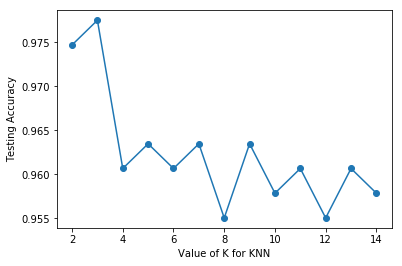

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def plotOptimalNeighbors():
    errors = []
    scores=[]
    for k in range(2,15):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_p = knn.predict(X_test)
        #errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
        scores.append(metrics.accuracy_score(y_test, y_p))
    #plt.plot(range(2,15), errors, 'o-')
    plt.plot(range(2,15), scores, 'o-')
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Testing Accuracy')
    plt.show()

plotOptimalNeighbors()

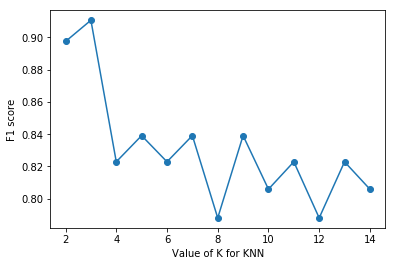

In [38]:
from sklearn import neighbors 
from sklearn.metrics import f1_score,confusion_matrix,roc_auc_score
f1_list=[]
k_list=[]
for k in range(2,15):
    clf=neighbors.KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    clf.fit(X_train,y_train)
    pred=clf.predict(X_test)
    f=f1_score(y_test,pred,average='macro')
    f1_list.append(f)
    k_list.append(k)
    
plt.plot(k_list, f1_list, 'o-')
plt.xlabel('Value of K for KNN')
plt.ylabel('F1 score')
plt.show()

### Classification & prediction
Il est extrêmement simple de former l''algorithme KNN et de faire des prédictions avec lui, en particulier lors de l''utilisation de Scikit-Learn.
La première étape consiste à importer la KNeighborsClassifierclasse depuis la `sklearn.neighbors` bibliothèque. Dans la deuxième ligne, cette classe est initialisée avec un paramètre, ie 'n_neigbours. Il s'agit essentiellement de la valeur de K. Il n'y a pas de valeur idéale pour K et elle est sélectionnée après test et évaluation, mais pour commencer, 5 semble être la valeur la plus couramment utilisée pour l'algorithme KNN.

In [6]:
#Classification
from sklearn.neighbors import KNeighborsClassifier
k=3
knn = KNeighborsClassifier(n_neighbors=k, metric="euclidean")
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [7]:
#prediction
y_pred = knn.predict(X_test)

## Evaluation
Pour évaluer un algorithme, la matrice de confusion, la précision, le rappel et le score f1 sont les mesures les plus couramment utilisées. Les méthodes confusion_matrixet classification_reportde sklearn.metricspeuvent être utilisées pour calculer ces métriques. Jetez un œil au script suivant:

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

def showConfusionMatrix(ytest,ypred):
    print("Confusion Matrix \n",confusion_matrix(ytest, ypred))
    print("Repport: \n",classification_report(ytest, ypred))
    
def showScore(knn, xtest, ytest):
    print('Score: %f' % knn.score(xtest,ytest))
    print('Erreur: %f' % (1-knn.score(xtest,ytest)))
    
def printMetrics(yTest, yPred):
    print("Accuracy: ", metrics.accuracy_score(yTest, yPred))
    print("Ajusted Rand Square",metrics.adjusted_rand_score(yTest, yPred))

In [9]:
showConfusionMatrix(y_test,y_pred)
showScore(knn, X_test,y_test)
printMetrics(y_test,y_pred)

Confusion Matrix 
 [[324   4]
 [ 18  10]]
Repport: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       328
           1       0.71      0.36      0.48        28

    accuracy                           0.94       356
   macro avg       0.83      0.67      0.72       356
weighted avg       0.93      0.94      0.93       356

Score: 0.938202
Erreur: 0.061798
Accuracy:  0.9382022471910112
Ajusted Rand Square 0.41590890242256523


In [10]:
from sklearn.model_selection import cross_val_score

def printCrusValidation(xTrain, yTrain, k=3):
    #create a new KNN model
    knn_cv = KNeighborsClassifier(n_neighbors=k)
    #train model with cv of 5 
    cv_scores = cross_val_score(knn_cv, xTrain, yTrain, cv=20)
    #print each cv score (accuracy) and average them
    print('Cross validation score\n',cv_scores)
    print('cv_scores mean:{}'.format(np.mean(cv_scores)))

printCrusValidation(X_train, y_train)

Cross validation score
 [0.95833333 0.95833333 0.95774648 0.92957746 0.92957746 0.94366197
 0.92957746 0.95774648 0.92957746 0.92957746 0.90140845 0.95774648
 0.95774648 0.91549296 0.95774648 0.95774648 0.98591549 0.90140845
 0.92857143 0.98571429]
cv_scores mean:0.9436602951039571


### Save Model
Nous allons sauvegarder le model pour pouvoir l'utiliser pour la prochaine fois sans faire l'apprentissage désormais.

In [52]:
import pickle
filename = 'knn_Model.sav'
pickle.dump(knn, open(filename, 'wb'))

In [12]:
import joblib
# save the model in disk
filename = 'knn_Model2.sav'
joblib.dump(knn, filename)

['knn_Model2.sav']

### Load Model
Pour réutiliser le model sans refaire l'apprentissage nous allons charger le model enregistrer

In [53]:
model = pickle.load(open(filename, 'rb'))

### Plot ROC Curve
Nous allos afficher les éléments et leur comportement après prediction

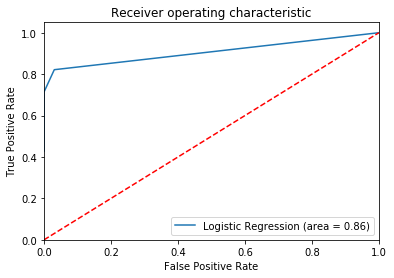

In [45]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Predict other Data
Nous allons maintenant tester la prédiction d'autres données qui ne sont pas les tests

In [46]:
path='../3-DataSet/dataFinale/p25/testSet_p25.csv'
#path='../3-DataSet/dataFinale/p27/testSet_p27.csv'
#path='../3-DataSet/dataFinale/p230/testSet_p30.csv'

#cols=["ECP","RC","MIN","MAX","MEAN","START","END","DURATION","CV","A1","A2","A3","A4"]
cols=["ECP","RC","MIN","MAX","MEAN","START","END","DURATION","CV","A1","A2","A3","A4","FP"]
toPredict = pd.read_csv(path,names=cols, sep=',')
toPredict.head(5)

,ECP,RC,MIN,MAX,MEAN,START,END,DURATION,CV,A1,A2,A3,A4,FP
0,3005FB63AC1F3681EC8815B921,9,-58.5,-52.0,-56.555556,1581420973596918,1581420974726948,1130030,-0.040071,3,0,6,0,0
1,E2806890000000001834376767,2,-63.0,-62.0,-62.500000,1581427757606159,1581427757711480,105321,-0.008000,0,0,2,0,0
2,E2806890000000001834531777,66,-63.5,-58.0,-60.045455,1581426772161856,1581426781271598,9109742,-0.016888,66,0,0,0,1
3,2005FB63EAC13681E4EC0FD224,4,-65.0,-59.0,-62.000000,1581420375415960,1581420375804651,388691,-0.038253,0,4,0,0,0
4,3005FB63AC1F3681EC88142830,7,-57.5,-45.0,-50.928571,1581414771515647,1581414773005717,1490070,-0.087408,7,0,0,0,0


In [48]:
#toPredict.loc[:,'RC':'A4']
X_toPredict = scaleData(toPredict.loc[:,'RC':'A4'])
y_toPredict = toPredict['FP']

new_pred = knn.predict(X_toPredict)

showConfusionMatrix(y_toPredict,new_pred)
showScore(knn, X_toPredict,y_toPredict)
printMetrics(y_toPredict, new_pred)

Confusion Matrix 
 [[217   1]
 [  2   6]]
Repport: 
              precision    recall  f1-score   support

          0       0.99      1.00      0.99       218
          1       0.86      0.75      0.80         8

avg / total       0.99      0.99      0.99       226

Score: 0.986726
Erreur: 0.013274
Accuracy:  0.986725663717
Ajusted Rand Square 0.781849563568


In [49]:
toPredict['IS_FP']=new_pred
toPredict

,ECP,RC,MIN,MAX,MEAN,START,END,DURATION,CV,A1,A2,A3,A4,FP,IS_FP
0,3005FB63AC1F3681EC8815B921,9,-58.5,-52.0,-56.555556,1581420973596918,1581420974726948,1130030,-0.040071,3,0,6,0,0,0
1,E2806890000000001834376767,2,-63.0,-62.0,-62.500000,1581427757606159,1581427757711480,105321,-0.008000,0,0,2,0,0,0
2,E2806890000000001834531777,66,-63.5,-58.0,-60.045455,1581426772161856,1581426781271598,9109742,-0.016888,66,0,0,0,1,1
3,2005FB63EAC13681E4EC0FD224,4,-65.0,-59.0,-62.000000,1581420375415960,1581420375804651,388691,-0.038253,0,4,0,0,0,0
4,3005FB63AC1F3681EC88142830,7,-57.5,-45.0,-50.928571,1581414771515647,1581414773005717,1490070,-0.087408,7,0,0,0,0,0
5,3005FB63AC1F3681EC88116627,2,-52.0,-52.0,-52.000000,1581419573582440,1581419573687269,104829,-0.000000,0,0,2,0,0,0
6,7336CEF1C1FE3682DEA1004C27,2,-54.5,-53.5,-54.000000,1581419574129930,1581419574275670,145740,-0.009259,0,0,2,0,0,0
7,7336CEF1C1FE3682DEA1004A31,4,-60.0,-52.5,-56.000000,1581415047199925,1581415047726415,526490,-0.058888,0,0,0,4,0,0
8,E2806890000000001834531775,62,-60.5,-57.5,-58.258065,1581429871609955,1581429880213044,8603089,-0.013326,62,0,0,0,1,1
9,7336CEF1C1FE3682DEA1005027,2,-56.5,-56.5,-56.500000,1581419574136143,1581419574289249,153106,-0.000000,0,0,2,0,0,0


### Export predict datas
Nous allons exporter les données predites en csv

In [109]:
#Export predict data
pathExport='../6-ClassifiedData/knn_predict_30.csv'
toPredict.to_csv(pathExport, index = None, header=True)